In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint
import itertools

In [2]:
max_length = 0
corpus = list()
labels = list()

with open(Path('./output/benign/all_benign.txt'), 'r') as f:
  lines = f.read().split('\n')[:-1]
  # print(lines[0][33:])
for line in lines:
  doc = line[33:]
  corpus.append(doc)
  labels.append(0)
  

In [3]:
with open(Path('./output/malware/all_malware.txt'), 'r') as f:
  lines = f.read().split('\n')[:-1]
  # print(lines[0][33:])
doc = ''
for line in lines:
  doc = line[33:]
  corpus.append(doc)
  labels.append(1)

In [4]:
labels = np.array(labels)

In [5]:
tokenizer = Tokenizer(split=' ')
tokenizer.fit_on_texts(corpus)
X = tokenizer.texts_to_sequences(corpus)
X = pad_sequences(X, maxlen=192000)
print(X.shape)

(2800, 192000)


In [6]:
X = X.reshape(-1, 32, 6000)
print(X.shape)

(2800, 32, 6000)


In [7]:
vocab_size = len(tokenizer.word_index) + 1
print(f'노드 개수: {vocab_size}, 한 개 밖에 없는 노드:', end=' ')
unique_word = 0
for k in tokenizer.word_docs:
  if tokenizer.word_docs[k] == 1:
    unique_word += 1
print(unique_word)

노드 개수: 26, 한 개 밖에 없는 노드: 0


In [8]:
model = Sequential()
model.add(Bidirectional(LSTM(units=32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True),
                        input_shape=(32, 6000)))
model.add(Bidirectional(LSTM(units=32, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 32, 64)           1544448   
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 1,569,345
Trainable params: 1,569,345
Non-trainable params: 0
_________________________________________________________________
None


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.3, random_state=42)
print(f'Train을 {X_train.shape}만큼, Test를 {X_test.shape}만큼 진행')

Train을 (1960, 32, 6000)만큼, Test를 (840, 32, 6000)만큼 진행


In [10]:
batch_size = 64
mc = ModelCheckpoint('./log/model.h5', save_best_only=True)
history = model.fit(X_train, y_train, epochs=100, batch_size=batch_size,
                    verbose=2, validation_split=0.1, callbacks=[mc])


Epoch 1/100
28/28 - 24s - loss: 0.6683 - accuracy: 0.5975 - val_loss: 0.6385 - val_accuracy: 0.6378 - 24s/epoch - 847ms/step
Epoch 2/100
28/28 - 15s - loss: 0.6220 - accuracy: 0.6706 - val_loss: 0.5842 - val_accuracy: 0.7041 - 15s/epoch - 531ms/step
Epoch 3/100
28/28 - 15s - loss: 0.5443 - accuracy: 0.7432 - val_loss: 0.5197 - val_accuracy: 0.7551 - 15s/epoch - 551ms/step
Epoch 4/100
28/28 - 15s - loss: 0.4642 - accuracy: 0.7744 - val_loss: 0.4814 - val_accuracy: 0.7755 - 15s/epoch - 541ms/step
Epoch 5/100
28/28 - 15s - loss: 0.4408 - accuracy: 0.7863 - val_loss: 0.4834 - val_accuracy: 0.7296 - 15s/epoch - 525ms/step
Epoch 6/100
28/28 - 15s - loss: 0.4476 - accuracy: 0.7880 - val_loss: 0.5236 - val_accuracy: 0.7398 - 15s/epoch - 527ms/step
Epoch 7/100
28/28 - 15s - loss: 0.4304 - accuracy: 0.8061 - val_loss: 0.4768 - val_accuracy: 0.7602 - 15s/epoch - 532ms/step
Epoch 8/100
28/28 - 15s - loss: 0.4036 - accuracy: 0.8078 - val_loss: 0.4598 - val_accuracy: 0.7755 - 15s/epoch - 526ms/step


In [11]:
model.load_weights('./log/model.h5')

In [12]:
y_pred = model.predict(X_test, verbose=1, batch_size=batch_size)
y_pred = [y >= 0.5 for y in y_pred]

print(metrics.classification_report(y_test, y_pred, digits=4))
with open('log/report.txt', 'w') as f:
  f.write(str(metrics.classification_report(y_test, y_pred, digits=4)))


14/14 [==============================] - 2s 104ms/step
              precision    recall  f1-score   support

           0     0.7771    0.9271    0.8455       425
           1     0.9069    0.7277    0.8075       415

    accuracy                         0.8286       840
   macro avg     0.8420    0.8274    0.8265       840
weighted avg     0.8412    0.8286    0.8267       840



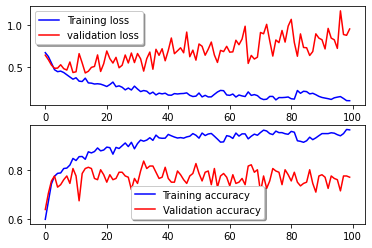

In [13]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r',
           label="validation loss", axes=ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'],
           color='r', label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)